<a href="https://colab.research.google.com/github/holly-hewitt/Abnormal-Infant-Movement-Detection/blob/main/Code/DataSetTestingClean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import tensorflow.compat.v1 as tf
#tf.enable_eager_execution(tf.ConfigProto(log_device_placement=False))
#tf.test.gpu_device_name()

import numpy as np
from sklearn.model_selection import KFold
from itertools import product
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking, LSTM, GRU
from sklearn.model_selection import KFold
# import early stopping
from tensorflow.keras.callbacks import EarlyStopping
import pickle
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import class_weight

from tensorflow.keras.layers import Input, Concatenate, Permute, Reshape, Multiply, Lambda, Add
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def specificity_score(y_true, y_pred):

    # Convert probabilities to binary predictions
    y_pred_bin = np.argmax(y_pred, axis=1)
    y_true_bin = np.argmax(y_true, axis=1)

    tn = np.sum((y_true_bin == 0) & (y_pred_bin == 0))
    fp = np.sum((y_true_bin == 0) & (y_pred_bin != 0))
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return specificity

In [4]:
def train_and_evaluate(dataset_names, create_model_fn, class_weights):

    outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    # Find best dataset to train and test model on
    #dataset_names = ['X_smoothed_mean_norm']

    for dataset_name in dataset_names:

         # Load in dataset from pickle
        with open(f'drive/MyDrive/Pickles/{dataset_name}.pickle', 'rb') as handle:
            dataset = pickle.load(handle)

        dataset = np.array(dataset)

        print(f'Working on dataset: {dataset_name}')

        accuracies = []
        sensitivities = []
        false_positive_rates = []
        specificities = []
        precisions = []

        fold = 1

        for train_index, test_index in outer_cv.split(dataset):

            # Print current progress
            print(f'Working on fold: {fold}')
            fold += 1

            X_train, X_test = dataset[train_index], dataset[test_index]
            Y_train, Y_test = abnormal_encoded[train_index], abnormal_encoded[test_index]

            X_train = X_train.astype('float32')
            Y_train = Y_train.astype('float32')
            X_test = X_test.astype('float32')
            Y_test = Y_test.astype('float32')

            model = create_model_fn(X_train.shape[1:])
            early_stopping = EarlyStopping(monitor='val_loss', patience=3)

            if class_weights:

                Y_train_classes = np.argmax(Y_train, axis=1)

                # Compute class weights
                cw = class_weight.compute_class_weight('balanced',
                                                    classes=np.unique(Y_train_classes),
                                                    y=Y_train_classes)

                class_weights_dict = dict(enumerate(cw))

                #Fit the model
                print('Fitting model')
                model.fit(X_train, Y_train, epochs=5, batch_size=4, validation_split=0.2, callbacks=[early_stopping], verbose=1, class_weight=class_weights_dict)

            else:
                #Fit the model
                print('Fitting model')
                model.fit(X_train, Y_train, epochs=5, batch_size=4, validation_split=0.2, callbacks=[early_stopping], verbose=1)

            # Predict the test set
            print('Predicting test set')
            Y_pred = model.predict(X_test)

            Y_pred_classes = np.argmax(Y_pred, axis=1)
            Y_test_classes = np.argmax(Y_test, axis=1)

            # Calulate accuracy, sensitivity, false positive rate, specificity and precision
            accuracies.append(accuracy_score(Y_test_classes, Y_pred_classes))
            sensitivities.append(recall_score(Y_test_classes, Y_pred_classes, average='macro'))
            false_positive_rates.append(1 - specificity_score(Y_test, Y_pred))
            specificities.append(specificity_score(Y_test, Y_pred))
            precisions.append(precision_score(Y_test_classes, Y_pred_classes, average='macro'))



        avg_accuracy = np.mean(accuracies)
        avg_sensitivity = np.mean(sensitivities)
        avg_false_positive_rate = np.mean(false_positive_rates)
        avg_specificity = np.mean(specificities)
        avg_precision = np.mean(precisions)

        std_accuracy = np.std(accuracies)
        std_sensitivity = np.std(sensitivities)
        std_false_positive_rate = np.std(false_positive_rates)
        std_specificity = np.std(specificities)
        std_precision = np.std(precisions)

        dataset_results[dataset_name]['Accuracy'] = (avg_accuracy, std_accuracy)
        dataset_results[dataset_name]['Sensitivity'] = (avg_sensitivity, std_sensitivity)
        dataset_results[dataset_name]['False Positive Rate'] = (avg_false_positive_rate, std_false_positive_rate)
        dataset_results[dataset_name]['Specificity'] = (avg_specificity, std_specificity)
        dataset_results[dataset_name]['Precision'] = (avg_precision, std_precision)

        for dataset_name, results in dataset_results.items():
            print(f'Dataset: {dataset_name}')
            for metric, (avg, std) in results.items():
                print(f'{metric}: {avg} +/- {std}')
            print('\n')


        # Delete dataset to free up memory
        del dataset
        del Y_pred
    return dataset_results

In [5]:
# Model functions

def create_cnn_model(shape, filters=32, kernel_size=3, dropout_rate=0.5):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=shape))  # Adjust the input_shape to match your dataset
    model.add(Conv1D(filters, kernel_size, activation='relu', input_shape=(19301, 16)))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))  # Reduced the number of neurons in the dense layer
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(shape, lstm_units=32, dropout_rate=0.5, output_classes=3):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=shape))
    model.add(LSTM(lstm_units, return_sequences=False))  # 'return_sequences=False' because we only need the last output
    model.add(Dropout(dropout_rate))
    model.add(Dense(lstm_units, activation='relu'))
    model.add(Dense(output_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_gru_model(shape, gru_units=32, dropout_rate=0.5, output_classes=3):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=shape))
    model.add(GRU(gru_units, return_sequences=False))  # return_sequences=False because we only need the last output
    model.add(Dropout(dropout_rate))
    model.add(Dense(gru_units, activation='relu'))
    model.add(Dense(output_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_lstm_model(shape, filters=32, kernel_size=3, lstm_units=64, dropout_rate=0.5, output_classes=3):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=shape))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(lstm_units, activation='relu'))
    model.add(Dense(output_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_gru_model(shape, filters=32, kernel_size=3, gru_units=64, dropout_rate=0.5, output_classes=3):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=shape))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(GRU(gru_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(gru_units, activation='relu'))
    model.add(Dense(output_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_attention_model(shape, lstm_units=64, dropout_rate=0.5, output_classes=3):
    inputs = Input(shape=shape)
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention = Dense(1, activation='tanh')(lstm_out)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(lstm_units)(attention)
    attention = Permute([2, 1])(attention)
    sent_representation = Multiply()([lstm_out, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(lstm_units,))(sent_representation)
    dropout = Dropout(dropout_rate)(sent_representation)
    dense = Dense(lstm_units, activation='relu')(dropout)
    outputs = Dense(output_classes, activation='softmax')(dense)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [8]:
 # Load in dataset from pickle
with open('drive/MyDrive/Pickles/abnormal_encoded.pickle', 'rb') as handle:
    abnormal_encoded = pickle.load(handle)
dataset_results = {'X_smoothed_mean_norm_month': {}, 'X_smoothed_median_norm_month': {}, 'X_smoothed_mean_norm': {}, 'X_smoothed_median_norm': {}}

In [27]:


cnn_dataset_result_cw = train_and_evaluate(['X_smoothed_mean_norm', 'X_smoothed_mean_norm_month','X_smoothed_median_norm', 'X_smoothed_median_norm_month'], create_cnn_model, True)



Working on dataset: X_smoothed_mean_norm
Working on fold: 1
Fitting model
Epoch 1/5
22/22 [==============================] - 2s 30ms/step - loss: 22.3467 - accuracy: 0.4235 - val_loss: 10.9162 - val_accuracy: 0.5909
Epoch 2/5
22/22 [==============================] - 0s 16ms/step - loss: 7.6254 - accuracy: 0.7412 - val_loss: 26.1706 - val_accuracy: 0.5000
Epoch 3/5
22/22 [==============================] - 0s 15ms/step - loss: 3.9040 - accuracy: 0.9059 - val_loss: 27.9859 - val_accuracy: 0.6818
Epoch 4/5
22/22 [==============================] - 0s 11ms/step - loss: 1.5618 - accuracy: 0.9059 - val_loss: 28.5547 - val_accuracy: 0.5909
Predicting test set
2/2 [==============================] - 0s 15ms/step
Working on fold: 2
Fitting model
Epoch 1/5
22/22 [==============================] - 1s 21ms/step - loss: 46.1282 - accuracy: 0.5412 - val_loss: 6.0454 - val_accuracy: 0.7273
Epoch 2/5
22/22 [==============================] - 0s 14ms/step - loss: 6.9497 - accuracy: 0.7176 - val_loss: 10.06

In [28]:
cnn_dataset_result_ncw = train_and_evaluate(['X_smoothed_mean_norm', 'X_smoothed_mean_norm_month','X_smoothed_median_norm', 'X_smoothed_median_norm_month'], create_cnn_model, False)


Working on dataset: X_smoothed_mean_norm
Working on fold: 1
Fitting model
Epoch 1/5
22/22 [==============================] - 1s 22ms/step - loss: 15.8563 - accuracy: 0.5529 - val_loss: 5.4335 - val_accuracy: 0.6818
Epoch 2/5
22/22 [==============================] - 0s 11ms/step - loss: 4.6145 - accuracy: 0.8000 - val_loss: 8.6626 - val_accuracy: 0.6364
Epoch 3/5
22/22 [==============================] - 0s 12ms/step - loss: 1.8578 - accuracy: 0.8824 - val_loss: 19.0609 - val_accuracy: 0.4091
Epoch 4/5
22/22 [==============================] - 0s 11ms/step - loss: 1.1123 - accuracy: 0.9412 - val_loss: 19.5823 - val_accuracy: 0.6818
Predicting test set
2/2 [==============================] - 0s 18ms/step
Working on fold: 2
Fitting model
Epoch 1/5
22/22 [==============================] - 2s 25ms/step - loss: 30.6900 - accuracy: 0.4588 - val_loss: 8.9566 - val_accuracy: 0.7727
Epoch 2/5
22/22 [==============================] - 0s 12ms/step - loss: 2.8553 - accuracy: 0.8824 - val_loss: 5.5423 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model
Epoch 1/5
22/22 [==============================] - 2s 29ms/step - loss: 99.9923 - accuracy: 0.4824 - val_loss: 36.3889 - val_accuracy: 0.6818
Epoch 2/5
22/22 [==============================] - 0s 17ms/step - loss: 21.3106 - accuracy: 0.7412 - val_loss: 19.0500 - val_accuracy: 0.6364
Epoch 3/5
22/22 [==============================] - 0s 16ms/step - loss: 2.9842 - accuracy: 0.8941 - val_loss: 64.2622 - val_accuracy: 0.1818
Epoch 4/5
22/22 [==============================] - 0s 16ms/step - loss: 16.1491 - accuracy: 0.7529 - val_loss: 30.6916 - val_accuracy: 0.8182
Epoch 5/5
22/22 [==============================] - 0s 16ms/step - loss: 9.5561 - accuracy: 0.8471 - val_loss: 41.8483 - val_accuracy: 0.4091
Predicting test set
2/2 [==============================] - 0s 17ms/step
Working on fold: 3
Fitting model
Epoch 1/5
22/22 [==============================] - 1s 22ms/step - loss: 32.6569 - accuracy: 0.4419 - val_loss: 9.9448 - val_accuracy: 0.5000
Epoch 2/5
22/22 [===============

In [31]:
lstm_dataset_results_cw = train_and_evaluate(['X_smoothed_mean_norm', 'X_smoothed_mean_norm_month','X_smoothed_median_norm', 'X_smoothed_median_norm_month'], create_lstm_model, True)


Working on dataset: X_smoothed_mean_norm
Working on fold: 1
Fitting model
Epoch 1/5
22/22 [==============================] - 19s 539ms/step - loss: 1.0659 - accuracy: 0.4824 - val_loss: 0.8730 - val_accuracy: 0.5455
Epoch 2/5
22/22 [==============================] - 11s 512ms/step - loss: 0.8162 - accuracy: 0.6471 - val_loss: 0.8216 - val_accuracy: 0.2727
Epoch 3/5
22/22 [==============================] - 9s 428ms/step - loss: 0.7692 - accuracy: 0.5529 - val_loss: 0.8627 - val_accuracy: 0.2727
Epoch 4/5
22/22 [==============================] - 10s 467ms/step - loss: 0.7146 - accuracy: 0.5765 - val_loss: 0.7524 - val_accuracy: 0.4545
Epoch 5/5
22/22 [==============================] - 11s 485ms/step - loss: 0.7599 - accuracy: 0.5647 - val_loss: 0.8375 - val_accuracy: 0.2727
Predicting test set
2/2 [==============================] - 2s 188ms/step
Working on fold: 2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model
Epoch 1/5
22/22 [==============================] - 16s 524ms/step - loss: 0.9982 - accuracy: 0.4588 - val_loss: 0.8210 - val_accuracy: 0.5909
Epoch 2/5
22/22 [==============================] - 9s 425ms/step - loss: 0.8482 - accuracy: 0.5294 - val_loss: 0.7614 - val_accuracy: 0.5000
Epoch 3/5
22/22 [==============================] - 10s 469ms/step - loss: 0.7796 - accuracy: 0.5529 - val_loss: 0.7631 - val_accuracy: 0.4091
Epoch 4/5
22/22 [==============================] - 10s 477ms/step - loss: 0.7328 - accuracy: 0.5765 - val_loss: 0.7401 - val_accuracy: 0.4545
Epoch 5/5
22/22 [==============================] - 10s 479ms/step - loss: 0.6885 - accuracy: 0.5765 - val_loss: 0.7358 - val_accuracy: 0.5000
Predicting test set
2/2 [==============================] - 2s 199ms/step
Working on fold: 3
Fitting model
Epoch 1/5
22/22 [==============================] - 16s 529ms/step - loss: 1.0734 - accuracy: 0.3721 - val_loss: 0.8975 - val_accuracy: 0.7273
Epoch 2/5
22/22 [============

In [32]:
lstm_dataset_results_ncw = train_and_evaluate(['X_smoothed_mean_norm', 'X_smoothed_mean_norm_month','X_smoothed_median_norm', 'X_smoothed_median_norm_month'], create_lstm_model, False)


Working on dataset: X_smoothed_mean_norm
Working on fold: 1
Fitting model
Epoch 1/5
22/22 [==============================] - 17s 537ms/step - loss: 0.9327 - accuracy: 0.5765 - val_loss: 0.6746 - val_accuracy: 0.7273
Epoch 2/5
22/22 [==============================] - 10s 466ms/step - loss: 0.7313 - accuracy: 0.6588 - val_loss: 0.6212 - val_accuracy: 0.7273
Epoch 3/5
22/22 [==============================] - 10s 436ms/step - loss: 0.7432 - accuracy: 0.6471 - val_loss: 0.6027 - val_accuracy: 0.7273
Epoch 4/5
22/22 [==============================] - 10s 479ms/step - loss: 0.6954 - accuracy: 0.6588 - val_loss: 0.6037 - val_accuracy: 0.7273
Epoch 5/5
22/22 [==============================] - 11s 485ms/step - loss: 0.6717 - accuracy: 0.6706 - val_loss: 0.5987 - val_accuracy: 0.7273
Predicting test set
2/2 [==============================] - 2s 271ms/step
Working on fold: 2
Fitting model
Epoch 1/5
22/22 [==============================] - 16s 538ms/step - loss: 1.1442 - accuracy: 0.4000 - val_loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model
Epoch 1/5
22/22 [==============================] - 18s 599ms/step - loss: 1.0389 - accuracy: 0.3765 - val_loss: 0.8271 - val_accuracy: 0.7727
Epoch 2/5
22/22 [==============================] - 10s 464ms/step - loss: 0.8565 - accuracy: 0.5647 - val_loss: 0.7638 - val_accuracy: 0.6818
Epoch 3/5
22/22 [==============================] - 10s 438ms/step - loss: 0.7969 - accuracy: 0.4588 - val_loss: 0.7289 - val_accuracy: 0.6818
Epoch 4/5
22/22 [==============================] - 10s 471ms/step - loss: 0.7480 - accuracy: 0.5412 - val_loss: 0.6802 - val_accuracy: 0.7727
Epoch 5/5
22/22 [==============================] - 11s 482ms/step - loss: 0.7209 - accuracy: 0.5765 - val_loss: 0.6900 - val_accuracy: 0.7727
Predicting test set
2/2 [==============================] - 2s 200ms/step
Working on fold: 3
Fitting model
Epoch 1/5
22/22 [==============================] - 16s 529ms/step - loss: 0.9257 - accuracy: 0.5581 - val_loss: 0.7363 - val_accuracy: 0.7273
Epoch 2/5
22/22 [===========

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on dataset: X_smoothed_median_norm_month
Working on fold: 1
Fitting model
Epoch 1/5
22/22 [==============================] - 16s 546ms/step - loss: 1.1009 - accuracy: 0.3176 - val_loss: 0.9155 - val_accuracy: 0.6818
Epoch 2/5
22/22 [==============================] - 10s 479ms/step - loss: 0.7847 - accuracy: 0.7059 - val_loss: 0.7166 - val_accuracy: 0.7273
Epoch 3/5
22/22 [==============================] - 10s 442ms/step - loss: 0.6975 - accuracy: 0.6824 - val_loss: 0.6516 - val_accuracy: 0.7273
Epoch 4/5
22/22 [==============================] - 10s 461ms/step - loss: 0.6636 - accuracy: 0.6588 - val_loss: 0.6527 - val_accuracy: 0.7273
Epoch 5/5
22/22 [==============================] - 11s 488ms/step - loss: 0.6715 - accuracy: 0.7176 - val_loss: 0.6677 - val_accuracy: 0.6818
Predicting test set
2/2 [==============================] - 2s 197ms/step
Working on fold: 2
Fitting model
Epoch 1/5
22/22 [==============================] - 18s 538ms/step - loss: 0.8927 - accuracy: 0.5176 - 

In [35]:
gru_dataset_results_cw = train_and_evaluate(['X_smoothed_mean_norm', 'X_smoothed_mean_norm_month','X_smoothed_median_norm', 'X_smoothed_median_norm_month'], create_gru_model, True)


Working on dataset: X_smoothed_mean_norm
Working on fold: 1
Fitting model
Epoch 1/5
22/22 [==============================] - 16s 519ms/step - loss: 0.9785 - accuracy: 0.5294 - val_loss: 0.7485 - val_accuracy: 0.7273
Epoch 2/5
22/22 [==============================] - 11s 486ms/step - loss: 0.9469 - accuracy: 0.4353 - val_loss: 0.7703 - val_accuracy: 0.4545
Epoch 3/5
22/22 [==============================] - 10s 475ms/step - loss: 0.7939 - accuracy: 0.4824 - val_loss: 0.7746 - val_accuracy: 0.3182
Epoch 4/5
22/22 [==============================] - 11s 489ms/step - loss: 0.7175 - accuracy: 0.5882 - val_loss: 0.7024 - val_accuracy: 0.6364
Epoch 5/5
22/22 [==============================] - 11s 509ms/step - loss: 0.7059 - accuracy: 0.6118 - val_loss: 0.7018 - val_accuracy: 0.6364
Predicting test set
2/2 [==============================] - 2s 196ms/step
Working on fold: 2
Fitting model
Epoch 1/5
22/22 [==============================] - 16s 520ms/step - loss: 1.2310 - accuracy: 0.4000 - val_loss

In [36]:
gru_dataset_results_ncw = train_and_evaluate(['X_smoothed_mean_norm', 'X_smoothed_mean_norm_month','X_smoothed_median_norm', 'X_smoothed_median_norm_month'], create_gru_model, False)


Working on dataset: X_smoothed_mean_norm
Working on fold: 1
Fitting model
Epoch 1/5
22/22 [==============================] - 16s 538ms/step - loss: 1.0175 - accuracy: 0.5294 - val_loss: 0.7850 - val_accuracy: 0.6818
Epoch 2/5
22/22 [==============================] - 10s 480ms/step - loss: 0.7630 - accuracy: 0.6588 - val_loss: 0.6883 - val_accuracy: 0.7273
Epoch 3/5
22/22 [==============================] - 11s 483ms/step - loss: 0.7079 - accuracy: 0.6588 - val_loss: 0.6519 - val_accuracy: 0.7273
Epoch 4/5
22/22 [==============================] - 11s 513ms/step - loss: 0.6852 - accuracy: 0.6118 - val_loss: 0.6507 - val_accuracy: 0.7273
Epoch 5/5
22/22 [==============================] - 10s 438ms/step - loss: 0.6604 - accuracy: 0.6941 - val_loss: 0.6394 - val_accuracy: 0.7273
Predicting test set
2/2 [==============================] - 4s 203ms/step
Working on fold: 2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model
Epoch 1/5
22/22 [==============================] - 18s 576ms/step - loss: 1.2260 - accuracy: 0.2941 - val_loss: 0.9084 - val_accuracy: 0.5455
Epoch 2/5
22/22 [==============================] - 10s 445ms/step - loss: 0.9263 - accuracy: 0.4353 - val_loss: 0.7567 - val_accuracy: 0.7727
Epoch 3/5
22/22 [==============================] - 11s 474ms/step - loss: 0.8210 - accuracy: 0.4235 - val_loss: 0.6919 - val_accuracy: 0.7727
Epoch 4/5
22/22 [==============================] - 11s 491ms/step - loss: 0.8126 - accuracy: 0.4588 - val_loss: 0.6656 - val_accuracy: 0.7727
Epoch 5/5
22/22 [==============================] - 11s 490ms/step - loss: 0.8311 - accuracy: 0.4118 - val_loss: 0.7063 - val_accuracy: 0.7273
Predicting test set
2/2 [==============================] - 2s 197ms/step
Working on fold: 3
Fitting model
Epoch 1/5
22/22 [==============================] - 16s 519ms/step - loss: 1.1640 - accuracy: 0.3837 - val_loss: 0.9749 - val_accuracy: 0.3182
Epoch 2/5
22/22 [===========

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on dataset: X_smoothed_mean_norm_month
Working on fold: 1
Fitting model
Epoch 1/5
22/22 [==============================] - 16s 533ms/step - loss: 0.8185 - accuracy: 0.6235 - val_loss: 0.6881 - val_accuracy: 0.7273
Epoch 2/5
22/22 [==============================] - 11s 495ms/step - loss: 0.7326 - accuracy: 0.6941 - val_loss: 0.6749 - val_accuracy: 0.6818
Epoch 3/5
22/22 [==============================] - 10s 438ms/step - loss: 0.7116 - accuracy: 0.6118 - val_loss: 0.6787 - val_accuracy: 0.6818
Epoch 4/5
22/22 [==============================] - 10s 475ms/step - loss: 0.6092 - accuracy: 0.7059 - val_loss: 0.6842 - val_accuracy: 0.6818
Epoch 5/5
22/22 [==============================] - 10s 479ms/step - loss: 0.5970 - accuracy: 0.6941 - val_loss: 0.6880 - val_accuracy: 0.6364
Predicting test set
2/2 [==============================] - 2s 192ms/step
Working on fold: 2
Fitting model
Epoch 1/5
22/22 [==============================] - 16s 505ms/step - loss: 1.1613 - accuracy: 0.4235 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model
Epoch 1/5
22/22 [==============================] - 16s 549ms/step - loss: 0.8612 - accuracy: 0.5765 - val_loss: 0.7338 - val_accuracy: 0.6818
Epoch 2/5
22/22 [==============================] - 11s 487ms/step - loss: 0.8490 - accuracy: 0.4000 - val_loss: 0.6544 - val_accuracy: 0.8636
Epoch 3/5
22/22 [==============================] - 11s 487ms/step - loss: 0.7290 - accuracy: 0.5294 - val_loss: 0.6374 - val_accuracy: 0.8636
Epoch 4/5
22/22 [==============================] - 12s 536ms/step - loss: 0.7392 - accuracy: 0.4588 - val_loss: 0.6246 - val_accuracy: 0.8636
Epoch 5/5
22/22 [==============================] - 10s 457ms/step - loss: 0.7263 - accuracy: 0.5529 - val_loss: 0.5854 - val_accuracy: 0.8182
Predicting test set
2/2 [==============================] - 2s 210ms/step
Working on fold: 3
Fitting model
Epoch 1/5
22/22 [==============================] - 16s 538ms/step - loss: 1.1375 - accuracy: 0.5116 - val_loss: 0.7151 - val_accuracy: 0.7273
Epoch 2/5
22/22 [===========

In [ ]:
cnn_lstm_results_ncw = train_and_evaluate(['X_smoothed_mean_norm', 'X_smoothed_mean_norm_month','X_smoothed_median_norm', 'X_smoothed_median_norm_month'],create_cnn_lstm_model,False)

Working on dataset: X_smoothed_mean_norm
Working on fold: 1
Fitting model
Epoch 1/5
 3/22 [===>..........................] - ETA: 4:44 - loss: 1.0460 - accuracy: 0.3333

TypeError: Invalid object type at position 0

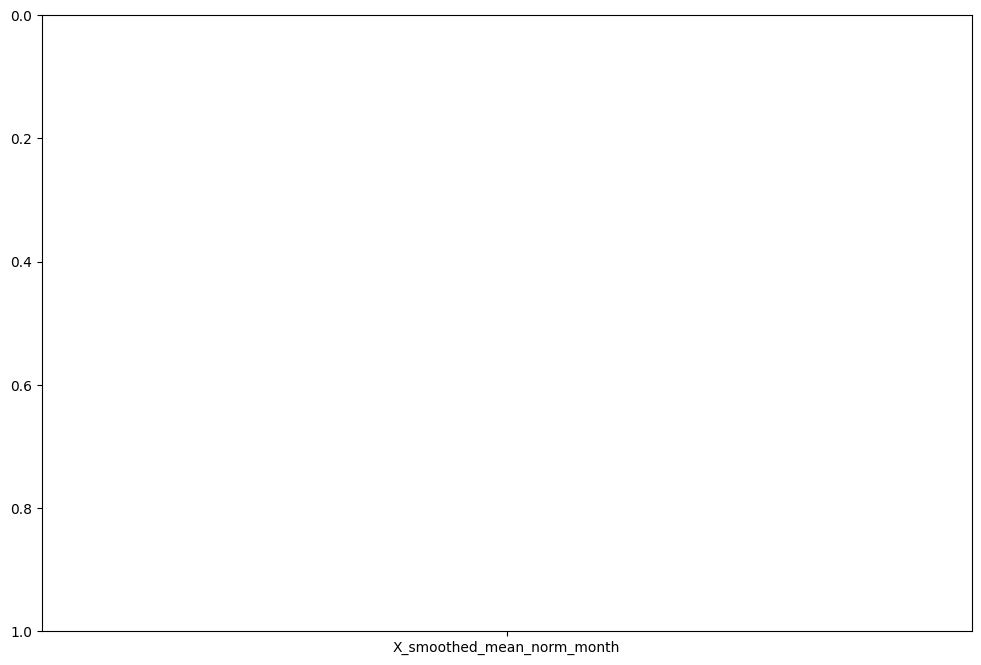

In [38]:
cnn_gru_results_ncw = train_and_evaluate(['X_smoothed_mean_norm', 'X_smoothed_mean_norm_month','X_smoothed_median_norm', 'X_smoothed_median_norm_month'],create_cnn_gru_model,False)